In [1]:
from kedro.framework.context import load_context
from kedro.config import ConfigLoader
from kedro.io import DataCatalog
from pathlib import Path
import pandas as pd

conf_loader = ConfigLoader(['../conf/base'])
conf_catalog = conf_loader.get("catalog*", "catalog/**")
new_catalog = DataCatalog.from_config(conf_catalog)

current_dir = Path.cwd()  # this points to 'notebooks/' folder
proj_path = current_dir.parent  # point back to the root of the project
context = load_context(proj_path)

In [2]:
%%time
df = context.catalog.load("ibov_dataset")
df.head()

2020-09-10 16:02:15,474 - kedro.io.data_catalog - INFO - Loading data from `ibov_dataset` (AppendableCSVDataSet)...
Wall time: 3.74 s


,data_pregao,cod_papel,preco_ultimo,num_negocios
0,2000-01-04 00:00:00,AVIL4FF,35.00,3.0
1,2000-01-05 00:00:00,AVIL4FF,35.00,2.0
2,2000-01-03 00:00:00,BBDC3FF,11.30,4.0
3,2000-01-03 00:00:00,BBDC4FF,13.87,36.0
4,2000-01-04 00:00:00,BBDC3,10.11,42.0


In [3]:
df.shape

(7158660, 4)

### First, I'm going to filter the stocks with more than one year of trades

In [4]:
days_of_trade = df.groupby('cod_papel').data_pregao.size()
stocks = list(days_of_trade[days_of_trade>250].index)
df = df.loc[df.cod_papel.isin(stocks), :]
df.shape

(4206711, 4)

### Let's take as target stocks only the top N traded stocks (volume) using December 19 as reference

In [5]:
TOP_N = 500

dec_filter = (df.data_pregao >= '2019-01-01') & (df.data_pregao <= '2019-01-31')
mean_trades = df.loc[dec_filter, :].groupby('cod_papel').num_negocios.mean()
stocks = list(mean_trades.sort_values(ascending=False).iloc[:TOP_N,].index)
df = df.loc[df.cod_papel.isin(stocks), :]
df.shape

(1265678, 4)

### Then I'm removing the duplicated values in the dataset

In [6]:
df = df.drop_duplicates(subset=['data_pregao','cod_papel'], keep='last')

### Next, we create a reference portfolio from which we want to find new uncorrelated stocks

In [7]:
portifolio = ['BBAS3','ITSA4','ITUB4','JBSS3','JHSF3','ODPV3','STBP3','MGLU3','BBSE3', 'CVCB3', 'BIDI4',              'STBP3', 'WEGE3']
df_port = df.loc[df.cod_papel.isin(portifolio), :]
df_port = df_port.drop_duplicates(subset=['data_pregao','cod_papel','preco_ultimo'])
df_port = df_port.pivot(index = 'data_pregao', columns='cod_papel', values='preco_ultimo')

2020-09-10 16:03:27,084 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


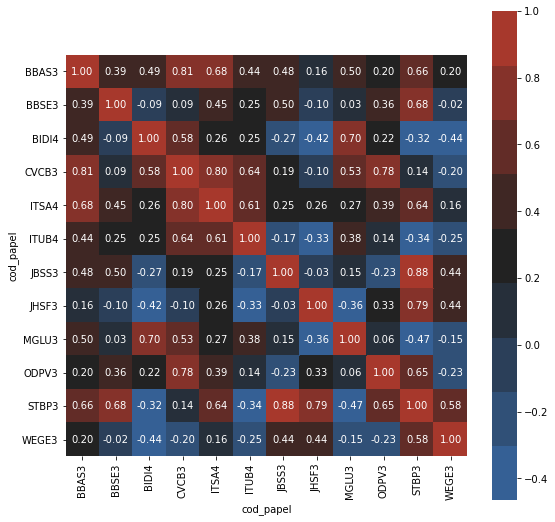

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="dark")
_, ax = plt.subplots(figsize=(9, 9))
corr = df_port.corr()

sns.heatmap(corr, cmap=cm, square=True, ax=ax, annot=True, fmt=".2f")
plt.yticks(rotation=0);

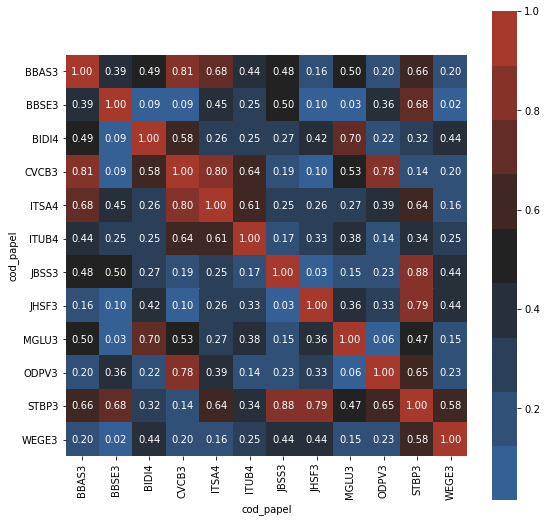

In [9]:
_, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(corr.abs(), cmap=cm, square=True, ax=ax, annot=True, fmt=".2f")
plt.yticks(rotation=0);

In [10]:
def normalize(df):
    max_v = df.max(axis='rows')
    min_v = df.min(axis='rows')
    return (df - min_v)/(max_v - min_v)

def get_least_correlated(df, portifolio, n=20):
    port = normalize(portifolio).sum(axis=1)
    df_cand = df.loc[:, [c for c in df.columns if c not in portifolio.columns]]
    res = {}
    for col in df_cand.columns:
        corr = df_cand[[col]].dropna().corrwith(port.dropna()).dropna().values
        if corr.shape[0] > 0:
            res[col] = corr
    res = pd.DataFrame.from_dict(res)
    return res


In [11]:
df = df.pivot(index = 'data_pregao', columns='cod_papel', values='preco_ultimo')

In [12]:
df.shape

(5121, 500)

In [86]:
MIN_DATE = '2010-01-01'
port_corr = get_least_correlated(df.loc[df.index>MIN_DATE, :], df_port.loc[df_port.index>MIN_DATE, :])

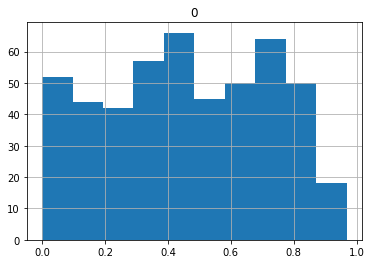

In [87]:
port_corr.transpose().abs().hist(bins=10);

### Let's analyze some of these correlated and uncorrelated stocks

In [96]:
port_corr.loc[:, port_corr.values.ravel() > 0.9].transpose().sort_values(by=0)

,0
RLOG3,0.902911
RLOG3F,0.902949
BRDT3F,0.909591
SANB11F,0.910590
SANB11,0.911016
BRDT3,0.911321
DIVO11,0.924722
BOVA11,0.935613
BOVA11F,0.937089
BBAS3F,0.939561


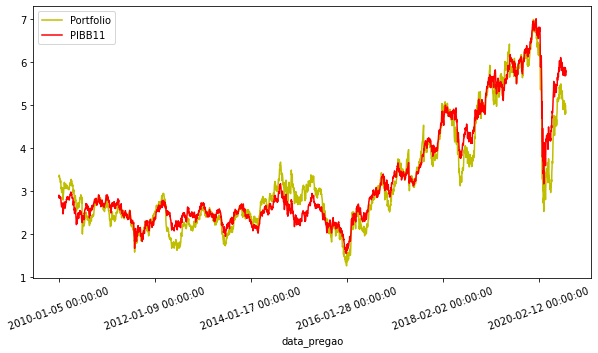

In [89]:
def plot_port_stock(df, portfolio, stock, min_date):
    _, ax = plt.subplots(figsize=(10, 5))
    df_stock = df.loc[~(df[stock].isnull()), stock]
    df_stock = normalize(df_stock)
    df_port = normalize(portfolio).sum(axis=1)
    df_stock = df_stock.loc[df_stock.index > min_date]
    df_port = df_port.loc[df_port.index > min_date]

    date = max(df_stock.index.min(), df_port.index.min())
    df_stock = df_stock.loc[df_stock.index > date] * 7
    df_port = df_port.loc[df_port.index > date]

    df_port.plot(ax=ax, color='y', rot=20)
    df_stock.plot(ax=ax, color='r', rot=20)
    ax.legend(['Portfolio', stock]);

plot_port_stock(df, df_port, 'PIBB11', MIN_DATE)

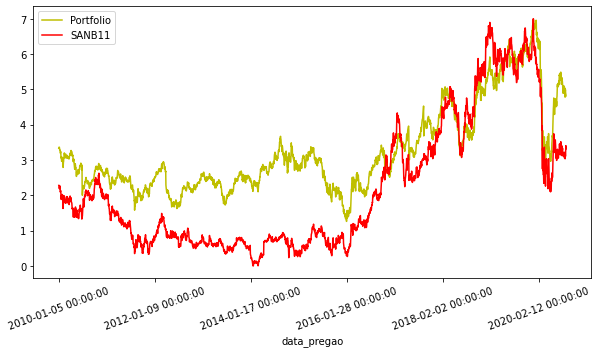

In [90]:
plot_port_stock(df, df_port, 'SANB11', MIN_DATE)

In [98]:
pd.set_option("display.max_columns", 1000)
port_corr.loc[:, port_corr.abs().values.ravel() < 0.1].transpose().sort_values(by=0)

,0
BBRK3,-0.096134
TIET3F,-0.080684
HGTX3,-0.079155
HGTX3F,-0.078950
OGXP3F,-0.072945
OGXP3,-0.071436
GUAR3,-0.063836
TRXL11,-0.057105
GUAR3F,-0.055664
POSI3,-0.044318


### We may have some good opportunities found

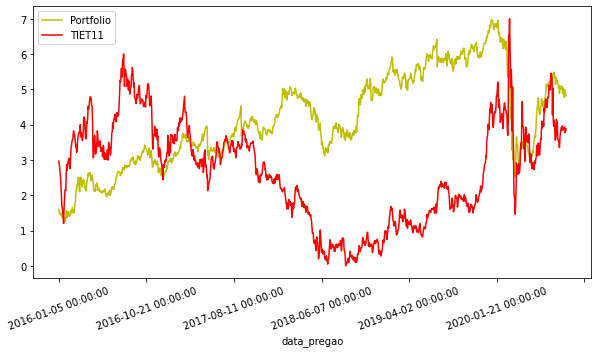

In [92]:
plot_port_stock(df, df_port, 'TIET11', MIN_DATE)

### But also we should watch out for false alarms

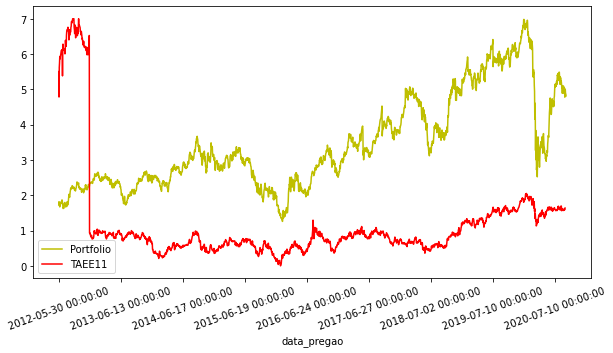

In [102]:
plot_port_stock(df, df_port, 'TAEE11', MIN_DATE)

### It's a good start, but we must know that selecting only uncorrelated stocks is not enough to succeed we need to find good uncorrelated stocks